In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import glob
import shutil
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy.signal as sig
from scipy import misc
from scipy import ndimage

from tqdm import tqdm
import cv2
from PIL import Image
Image.MAX_IMAGE_PIXELS = 7000 * 7000
from IPython.display import clear_output

import random

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

import timm
import torch
import torchvision
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CosineAnnealingLR, CyclicLR, ExponentialLR, OneCycleLR
from torchvision import models, transforms
from torch.nn import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

def set_seed(seed=12345):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)   
set_seed()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
path = '/kaggle/input/UBC-OCEAN'

In [3]:
df = pd.read_csv(os.path.join(path, 'train.csv'))

def add_path_images(directory, df):
    
    dir_ = Path(directory)
    files = sorted(list(dir_.rglob('*.png')))
    image_id = [int(path.name.split('.')[0].split('_')[0]) for path in files]
    name_column_path = files[0].parent.name
    dff = pd.DataFrame(np.array([files, image_id]).T, columns = [name_column_path, 'image_id'])
    df = df.merge(dff, on = 'image_id', how = 'left')

    return df
    
for dir_ in (f'{path}/train_images/', f'{path}/train_thumbnails/'):
    df = add_path_images(dir_, df)
    
df.loc[df['train_thumbnails'].isna(), 'train_thumbnails'] = df.loc[df['train_thumbnails'].isna()]['train_images']
df.head(2)

,image_id,label,image_width,image_height,is_tma,train_images,train_thumbnails
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_images/4.png,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_images/66.png,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...


In [4]:
resize = 512
batch_size = 8
n_classes = len(df.label.unique())
n_classes

5

## AUGMENTATION TMA (Gaussian-Laplacian Pyramid Blending)

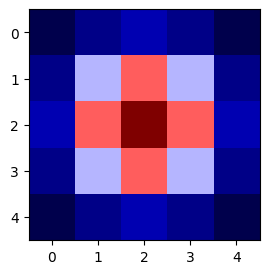

In [5]:
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

plt.figure(figsize=(3,3))
plt.imshow(kernel, cmap='seismic')
plt.show()

In [6]:
def interpolate(image):
    """
    Interpolates an image with upsampling rate r = 2
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    # Upsample
    image_up[::2, ::2] = image
    # Blur (we need to scale this up since the kernel has unit area)
    # (The length and width are both doubled, so the area is quadrupled)
    #return sig.convolve2d(image_up, 4*kernel, 'same')
    return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates an image with downsampling rate r=2.
    """
    image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
    # Downsample
    return image_blur[::2, ::2]                                
               
                                      
# here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
    image  : the original image (i.e. base of the pyramid)
    Returns :
    G   : the Gaussian pyramid
    L   : the Laplacian pyramid
    """
    # Initialize pyramids
    G = [image, ]
    L = []

    # Build the Gaussian pyramid to maximum depth
    while image.shape[0] >= 2 and image.shape[1] >= 2:
        image = decimate(image)
        G.append(image)

   # Build the Laplacian pyramid
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L

# Build Gaussian pyramid and Laplacian pyramids from images A and B, also mask
def pyramidBlending(A, B, mask):
    [GA, LA] = pyramids(A)
    [GB ,LB] = pyramids(B)
    # Build a Gaussian pyramid GR from selected region R (mask that says which pixels come from left and which from right)
    [Gmask, LMask] = pyramids(mask)
    # Form a combined pyramid LS from LA and LB using nodes of GR as weights
    # Equation: LS(i, j) = GR(I, j)*LA(I, j) + (1-GR(I, j)* LB(I, j))
    # Collapse the LS pyramid to get the final blended image
    blend = []
    for i in range(len(LA)):
        # LS = np.max(Gmask[i])*LA[i] + (1-np.max(Gmask[i]))*LB[i]
        # make sure the color with in 255 (white)
        LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
        blend.append(LS)
    return blend

# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
    rows, cols = pyramid[0].shape
    res = np.zeros((rows, cols + cols//2), dtype= np.double)
    # start the smallest pyramid so we need to reverse the order
    revPyramid = pyramid[::-1]
    stack = revPyramid[0]
    # start with the second index
    for i in range(1, len(revPyramid)):
        stack = interpolate(stack) + revPyramid[i] # upsampling simultaneously
    return stack
   
# Besides pyramid Blending, we need to blend image's color
def colorBlending(img1, img2, mask, filename, i=0):
    # split to 3 basic color, then using pyramidBlending and reconstruct it, respectively
    img1R,img1G,img1B = cv2.split(img1)
    img2R,img2G,img2B = cv2.split(img2)
    # reconstruct each color channel and convert to uint8 to return proper img
    R = reconstruct(pyramidBlending(img1R, img2R, mask))
    G = reconstruct(pyramidBlending(img1G, img2G, mask))
    B = reconstruct(pyramidBlending(img1B, img2B, mask))
    img = cv2.merge((R, G, B))#.astype('uint8')
    cv2.imwrite(filename, img)
    

In [7]:
def plot_blended_img(img_0, img_1, mask, title, filename):
    plt.figure(figsize=(16,9))
    
    plt.subplot(1,4,1)
    plt.imshow(img_0)
    plt.title('image 0')
    
    plt.subplot(1,4,2)
    plt.imshow(img_1)
    plt.title('image 1')
    
    plt.subplot(1,4,3)
    plt.imshow(mask,cmap='gray')
    plt.title('mask')
    
    plt.subplot(1,4,4)
    blended_img = cv2.imread(filename)
    plt.imshow(blended_img)
    plt.title('blended image')
    
    plt.suptitle(f'{title}', fontsize=20, y=0.75)
    plt.tight_layout()
    plt.show()

In [ ]:
labels_tma = df.label.unique()
os.makedirs('/kaggle/working/tma_aug', exist_ok=True)

mask0 = np.zeros((resize,resize))
mask0[:, resize//2:] = 255
random_label = random.choice(labels_tma)

augmentation_tma = []
for label in tqdm(labels_tma):
    title = f'Label {label} is_tma image'
    df_label = df.loc[(df['is_tma']==1)&(df['label']==label)] 
    for i, file_0 in enumerate(df_label.train_thumbnails.unique()):
        img_0 = cv2.resize(cv2.imread(str(file_0)), (resize, resize))
        for y, file_1 in enumerate(df_label.train_thumbnails.unique()):
            if file_0!=file_1:
                id_ = f'{i}{y}00000'
                filename = f'/kaggle/working/tma_aug/{id_}.png'
                img_1 = cv2.resize(cv2.imread(str(file_1)), (resize, resize))
                colorBlending(img_0, img_1, mask0, filename)
                if label == random_label:
                    plot_blended_img(img_0, img_1, mask0, title, filename)
                augmentation_tma.append([id_, label, True, Path(filename)])
                
augmentation_tma = pd.DataFrame(augmentation_tma, columns = ['image_id','label','is_tma','train_thumbnails'])
augmentation_tma.to_csv('/kaggle/working/tma_aug/tma_aug.csv', index = False)             

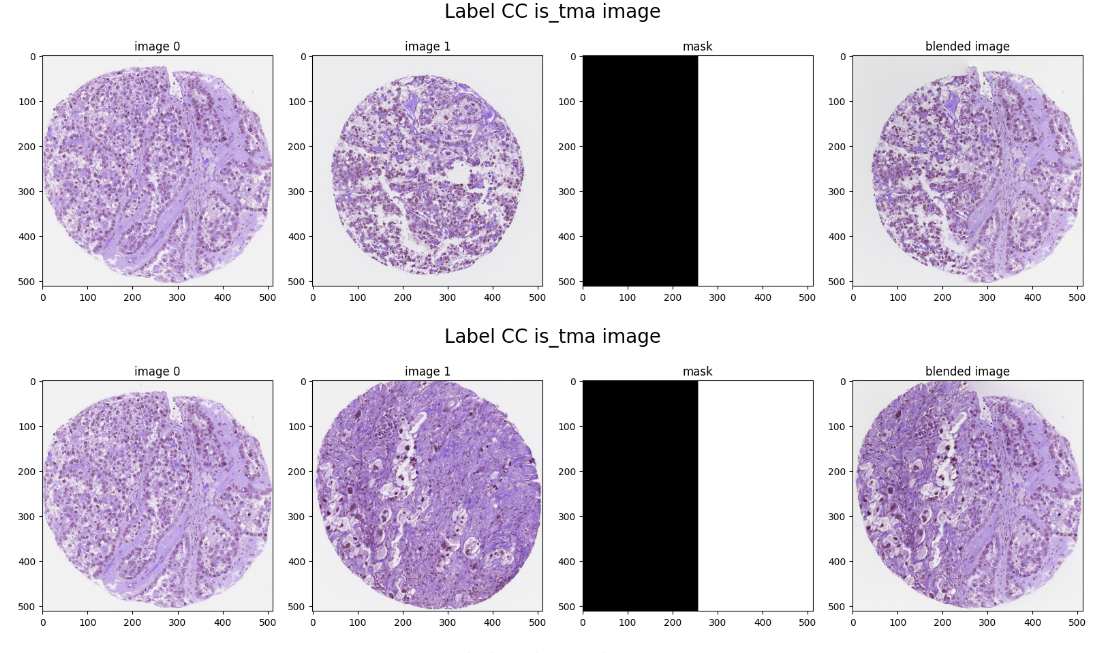

In [9]:
labels_tma = df.label.unique()
os.makedirs('/kaggle/working/tma_aug_random', exist_ok=True)

random_label = random.choice(labels_tma)

augmentation_tma = []
for label in tqdm(labels_tma):
    title = f'Label {label} is_tma image'
    df_label = df.loc[(df['is_tma']==1)&(df['label']==label)] 
    for i, file_0 in enumerate(df_label.train_thumbnails.unique()):
        img_0 = cv2.resize(cv2.imread(str(file_0)), (resize,resize))
        for y, file_1 in enumerate(df_label.train_thumbnails.unique()):
            mask0 = np.zeros((resize,resize))
            mask0[random.randint(0, resize//2):random.randint(resize//2, resize), random.randint(0, resize//2):random.randint(resize//2, resize)] = 255
            if file_0!=file_1:
                id_ = f'{i}{y}00001'
                filename = f'/kaggle/working/tma_aug_random/{id_}.png'
                img_1 = cv2.resize(cv2.imread(str(file_1)), (resize,resize))
                colorBlending(img_0, img_1, mask0, filename)
                #if label == random_label:
                    #plot_blended_img(img_0, img_1, mask0, title, filename)
                augmentation_tma.append([id_, label, True, Path(filename)])

augmentation_tma_random = pd.DataFrame(augmentation_tma, columns = ['image_id','label','is_tma','train_thumbnails'])
augmentation_tma_random.to_csv('/kaggle/working/tma_aug_random/tma_aug.csv', index = False)

100%|██████████| 5/5 [01:17<00:00, 15.45s/it]


In [10]:
augmentation_tma = pd.read_csv('/kaggle/working/tma_aug/tma_aug.csv')
df = pd.concat([df, augmentation_tma], keys = ['image_id','label','is_tma','train_thumbnails'], ignore_index=True)
augmentation_tma_random = pd.read_csv('/kaggle/working/tma_aug_random/tma_aug.csv')
df = pd.concat([df, augmentation_tma_random], keys = ['image_id','label','is_tma','train_thumbnails'], ignore_index=True)
df

,image_id,label,image_width,image_height,is_tma,train_images,train_thumbnails
0,4,HGSC,23785.0,20008.0,False,/kaggle/input/UBC-OCEAN/train_images/4.png,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871.0,48195.0,False,/kaggle/input/UBC-OCEAN/train_images/66.png,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
2,91,HGSC,3388.0,3388.0,True,/kaggle/input/UBC-OCEAN/train_images/91.png,/kaggle/input/UBC-OCEAN/train_images/91.png
3,281,LGSC,42309.0,15545.0,False,/kaggle/input/UBC-OCEAN/train_images/281.png,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
4,286,EC,37204.0,30020.0,False,/kaggle/input/UBC-OCEAN/train_images/286.png,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
...,...,...,...,...,...,...,...
733,3400001,MC,NaN,NaN,True,NaN,/kaggle/working/tma_aug_random/3400001.png
734,4000001,MC,NaN,NaN,True,NaN,/kaggle/working/tma_aug_random/4000001.png
735,4100001,MC,NaN,NaN,True,NaN,/kaggle/working/tma_aug_random/4100001.png
736,4200001,MC,NaN,NaN,True,NaN,/kaggle/working/tma_aug_random/4200001.png


## PREPARATION FOR TRAINING

In [11]:
class UBCDataset(Dataset):

    def __init__(self, files,labels,image_id,transform, resize):
        self.files = files
        self.labels = labels
        self.image_id = image_id
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        self.transform = transform
        self.size = resize
        
    def __len__(self):
        return len(self.files)
    
    def resize_image(self, img):
        width, height = img.shape[1], img.shape[0]
        if width>height:
            s = self.size/width
            height_,width_ = int(s*height), self.size
            img = cv2.resize(img, (self.size, height_))
        else: 
            s = self.size/height
            width_, height_ = int(s*width), self.size
            img = cv2.resize(img, (width_, self.size))
        
        mask = np.full((self.size,self.size, 3), 255, dtype = np.uint8)
        x_center = (self.size - width_)//2
        y_center = (self.size - height_)//2
        mask[y_center:y_center+height_, x_center:x_center+width_] = img   
        return mask        
    
    def __getitem__(self, index):
        img_name = str(self.files[index])
        img = cv2.imread(img_name)
        img = cv2.resize(img, (resize, resize), interpolation = cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(3,3))
        cl = clahe.apply(l_channel)
        limg = cv2.merge((cl,a,b))
        img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        image_id = self.image_id[index]
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        
        sample = {'image': img,'label': y,'id': image_id}       
        sample['image'] = self.transform(image=sample['image'])
       
        return sample['image']['image'], sample['label'], sample['id']

In [12]:
class_weights = Counter(df['label'].values)
class_weights = [df.shape[0]/class_weights[i] for i in sorted(df['label'].unique())]
class_weights = [val/sum(class_weights) for val in class_weights]
class_weights

[0.1788244797094492,
 0.15156465048544782,
 0.09487252931150168,
 0.285708076777166,
 0.2890302637164353]

In [13]:
skf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=12345)

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.label, groups=df.image_id)):
      df.loc[val_ , 'kfold'] = int(fold)

In [14]:
epochs = 18
t_max = df[df['kfold']!=0].shape[0]*epochs//batch_size
t_max

1503

In [15]:
normalize = [
    ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),    
    ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ((0.8721593659261734, 0.7799686061900686, 0.8644588534918227), (0.08258995918115268, 0.10991684444009092, 0.06839816226731532)),
    ((0.48828688, 0.42932517, 0.49162089), (0.41380908, 0.37492874, 0.41795654))
]
transform  = A.Compose([
      A.Resize(resize, resize),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.RandomBrightnessContrast(p=0.75),
      A.RandomRotate90(p=0.5),
      A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=60, p=0.5),
      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
      A.OneOf([A.GaussNoise(var_limit=[10, 50]), A.GaussianBlur(), A.MotionBlur()], p=0.3),
      #A.ElasticTransform (alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=0.5),
      A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
      A.CoarseDropout(max_holes=1, max_width=int(resize*0.3), max_height=int(resize*0.3), fill_value=0, p=0.3),
      A.Normalize(*normalize[-1], max_pixel_value=255.0, p=1.0),
      ToTensorV2()], p=1.)

transform_  = A.Compose([
      A.Resize(resize, resize),
      A.Normalize(*normalize[-1], max_pixel_value=255.0, p=1.0),
      ToTensorV2()], p=1.)

In [16]:
def imshow_(inp, norm=None, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([*norm[0]])
    std = np.array([*norm[-1]])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp) 
    try: 
        if title is not None:
            plt_ax.set_title(title)
    except:
        plt.title(title)
    plt_ax.grid(False)

In [17]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = UBCDataset(df_train.train_thumbnails.values, df_train.label.values, df_train.image_id.values, transform, resize)
    valid_dataset = UBCDataset(df_valid.train_thumbnails.values, df_valid.label.values, df_valid.image_id.values, transform_, resize)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)
    
    return train_dataset, valid_dataset, train_loader, valid_loader


train_dataset, valid_dataset, train_loader, valid_loader = prepare_loaders(df, 0)

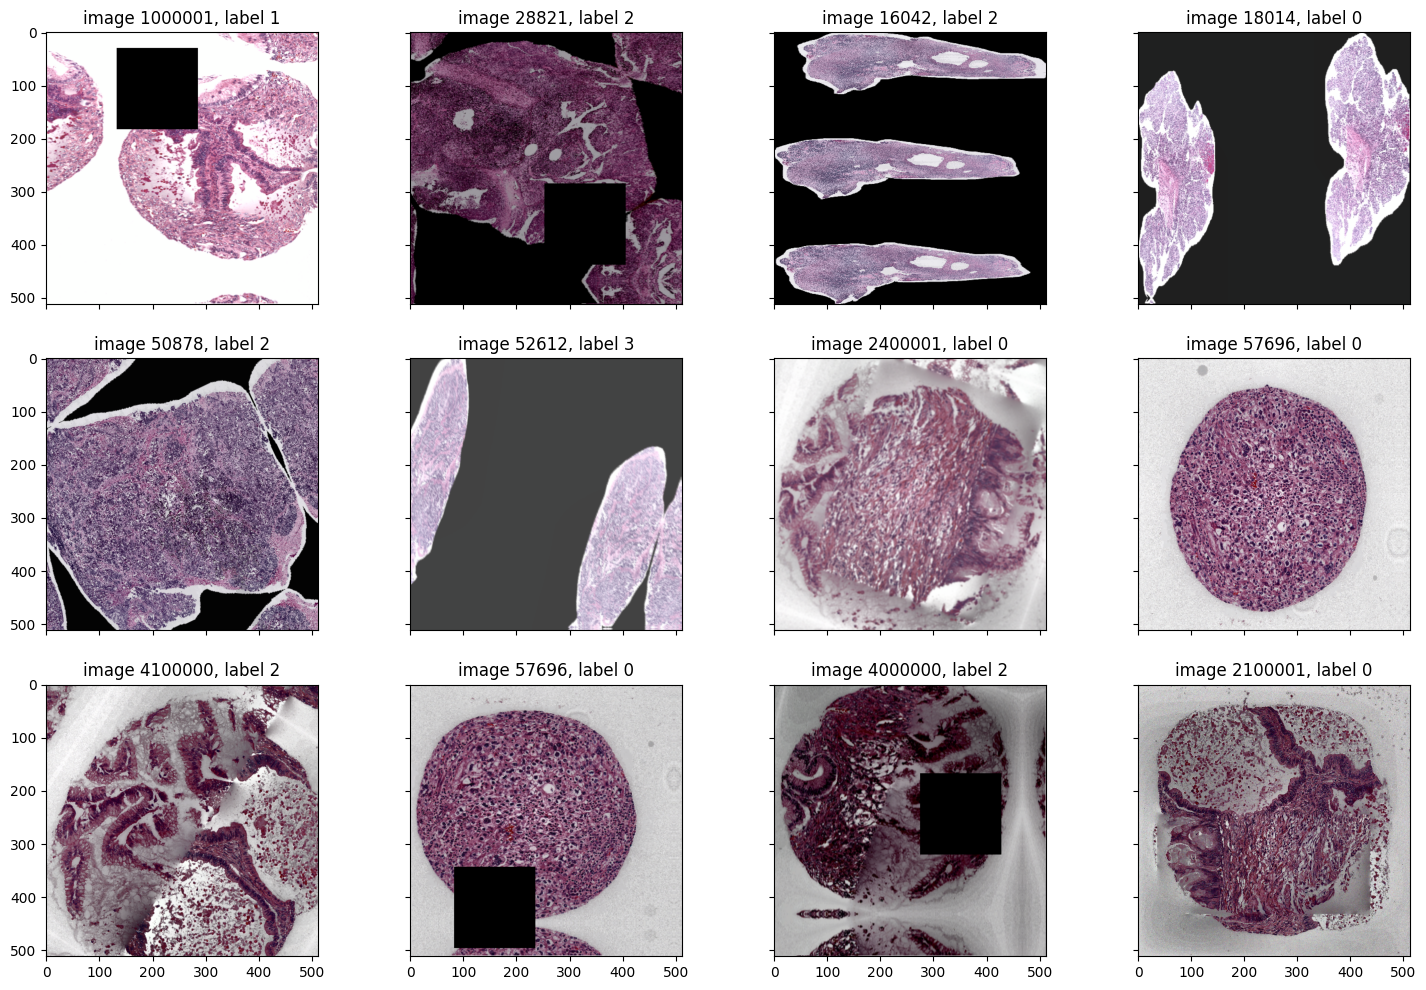

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(18, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(train_dataset)))
    im_val, label, id_ = train_dataset[random_characters]
    imshow_(im_val, normalize[-1], title=f'image {id_}, label {label}', plt_ax=fig_x)

## TRAINING

In [19]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

In [20]:
def show_result(data, best_score):
    plt.figure(figsize=(22, 7))
        
    plt.subplot(1, 2, 1)
    sns.lineplot(data=data, x='epoch', y='train_loss', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_loss', color = 'cornflowerblue')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'])
    plt.title('Loss values')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=data, x='epoch', y='train_accuracy', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_accuracy', color = 'cornflowerblue')
    sns.lineplot(data=data, x='epoch', y=0.5, style=True, dashes=[(3,3)], color = 'tan')
    mask = np.array(data['valid_accuracy'])==best_score
    plt.scatter(np.array(data['epoch'])[mask], np.array(data['valid_accuracy'])[mask], color='salmon', s=40, marker='^')
    plt.ylabel('score')
    plt.legend(['train_accuracy', 'valid_accuracy', 'threshold'])
    plt.title('Score: accuracy')
        
    plt.show()   

In [21]:
def train(model, optimizer, loss_fn, epochs, loaders, scheduler1=None, scheduler2=None, ):
    
    best_score = 0
    for epoch in range(1, epochs+1):
        model.train()
        scaler =  torch.cuda.amp.GradScaler() 
        result['epoch'].append(epoch)
        for mode, dataloader in tqdm(loaders.items()):
            running_loss, balance_acc, processed_data, valid_loss = 0,[],0, 0
            
            for X_batch, Y_batch, _ in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device, dtype=torch.long)

                if mode =='train':
                    model.train()
                    optimizer.zero_grad() 
                    Y_pred = model(X_batch)
                else: 
                    model.eval()  
                    with torch.no_grad(): 
                        Y_pred = model(X_batch)
                
                loss = loss_fn(Y_pred, Y_batch)
                preds = torch.argmax(Y_pred, 1)
                running_loss += loss.item() * X_batch.size(0)
                processed_data += X_batch.size(0)             
                balance_acc.append(balanced_accuracy_score(Y_batch.detach().cpu().numpy(), preds.detach().cpu().numpy()))
                
                if mode =='train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
            
            loss_score = running_loss/processed_data
            accuracy = np.mean(balance_acc)
            result[str(mode)+'_loss'].append(loss_score)
            result[str(mode)+'_accuracy'].append(accuracy)
            
            if mode =='valid':
                if accuracy > best_score:
                    best_score = accuracy
                    torch.save(model.state_dict(), f'weights.bin')   
                valid_loss = loss_score
            lr = optimizer.param_groups[0]['lr']
            scheduler1.step(valid_loss)
            scheduler2.step()
            
        clear_output(wait=True)
        print(f'epoch training: {epoch}, lr optimizer: {lr}, loss value validate:{valid_loss:10.4f}, accuracy validate:{accuracy:10.4f}') #
        print()

        show_result(result, best_score)
        
        torch.cuda.empty_cache()
        gc.collect()

In [22]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True, checkpoint_path=None):
        super(UBCModel, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_m.in21k_ft_in1k', pretrained=True,
                                       pretrained_cfg_overlay=dict(file='/kaggle/input/tf-efficientnetv2-m-in21k-ft-in1k/pytorch_model.bin'))
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output

    
model = UBCModel('tf_efficientnetv2_m.in21k_ft_in1k', 5)

In [23]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-6)
scheduler1 = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
scheduler2 = CyclicLR(optimizer, base_lr=5e-6, max_lr=1e-4, cycle_momentum=False, step_size_up=5,  mode='triangular')
criterion = nn.CrossEntropyLoss(torch.FloatTensor(class_weights).to(device)) 

loaders = {'train': train_loader, 'valid': valid_loader}

epoch training: 18, lr optimizer: 0.0001, loss value validate:    1.4417, accuracy validate:    0.4466



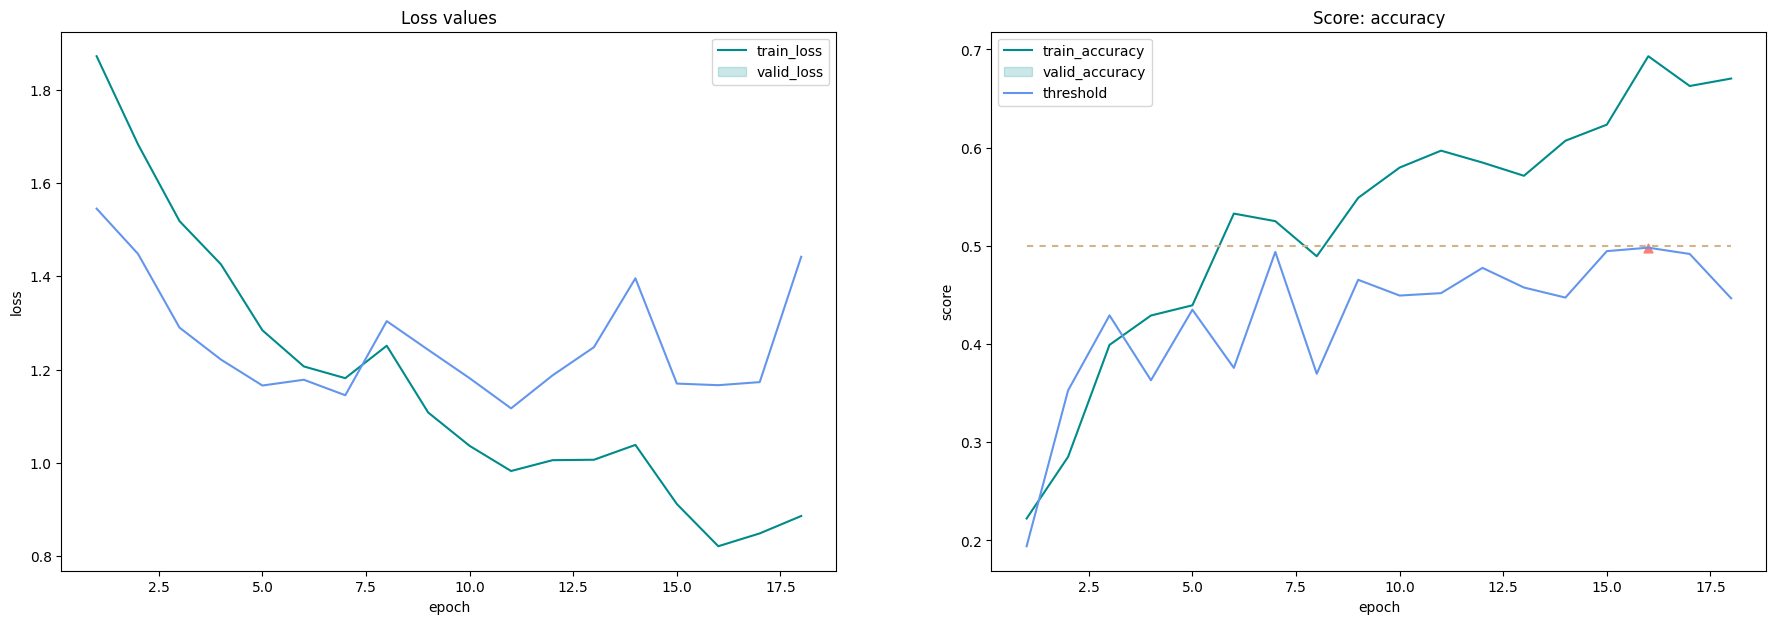

In [25]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_accuracy':[],'valid_accuracy':[]
}
epochs = 18
train(model.to(device), optimizer, criterion, epochs, loaders, scheduler1=scheduler1, scheduler2=scheduler2)